# Курсовой проект

## Задание

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Наименование файлов с данными

course_project_train.csv - обучающий датасет
course_project_test.csv - тестовый датасет

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

##### Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

### Обзор данных

#### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

### Загрузка библиотек

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb
#import lightgbm as lgbm
#import catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import random

import warnings
warnings.filterwarnings('ignore')

### Пути к директориям и файлам

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [7]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [8]:
df_test.shape

(2500, 16)

### Оптимизация занимаемой памяти

In [9]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [10]:
df_train = optimizing_df(df_train)
df_test = optimizing_df(df_test)

### Типы данных

In [11]:
df_train.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                     uint8
dtype: object

## Изучение и обработка признаков -  Feature Exploring  & Engineering

#### Выделение признакового описания и целевой переменной

In [104]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Bankruptcies', 'Months since last delinquent',
                    'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership', 'Years in current job', 
                    'Purpose', 'Term' ]

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Credit Score', 'Bankruptcies', 'Months since last delinquent', 'Current Credit Balance', 'Monthly Debt']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Целевая переменная - Credit Default

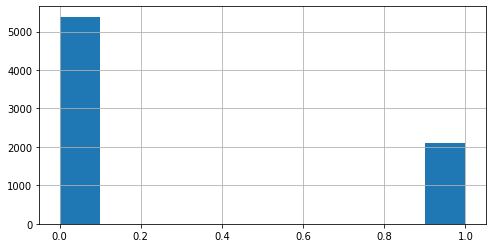

In [31]:
plt.figure(figsize = (8,4))
df_train['Credit Default'].hist()
plt.show()

In [25]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

**Очевидна разбалансировка классов, которую необходимо будет выровнять**

### Изучение  признаков

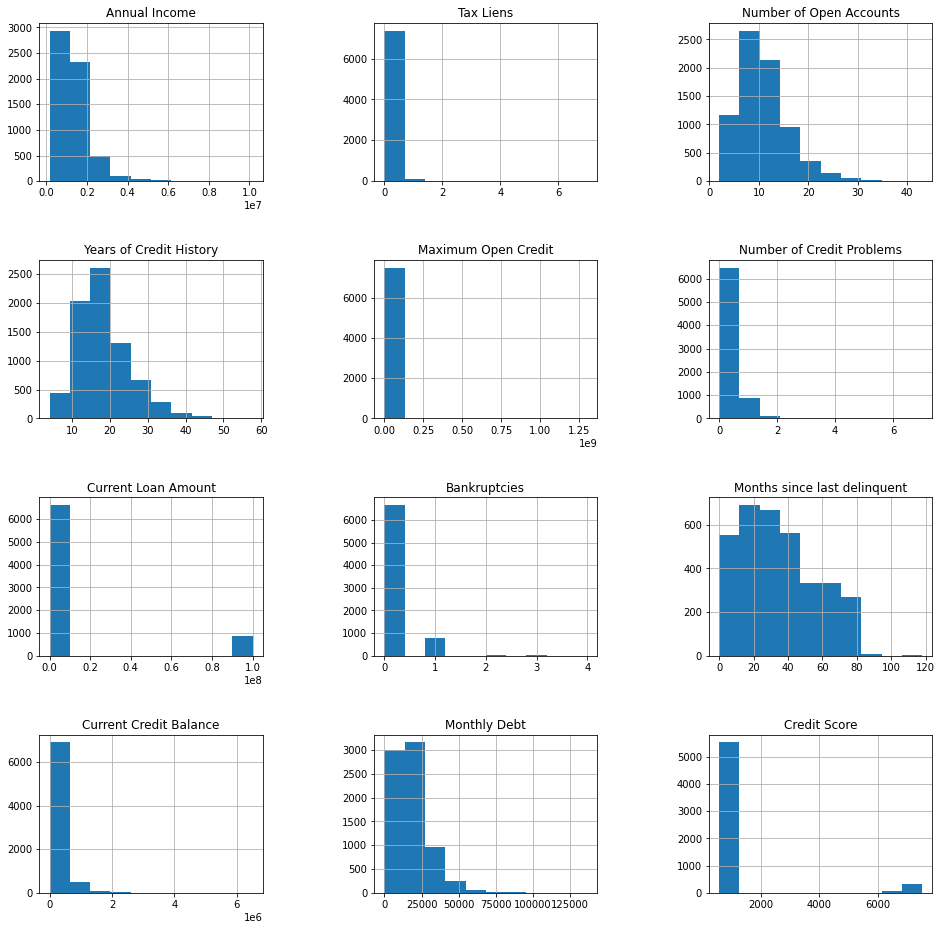

In [13]:
# распределение признаков в тренировочном датасете
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

#### Изучим признаки подробнее

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [16]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Признаки, содержащие пропуски - **Annual Income, Months since last delinquent, Years in current job, Credit Score** . Наибольшее количество пропусков в признаке Months since last delinquent, необходимо его изучить внимательнее

### Числовые признаки

In [114]:
for num, column in enumerate(df_train[NUM_FEATURE_NAMES]):
    print(str(num) + ' : ' + str(column) + '\n\n' + str(df_train[column].value_counts()) + '\n' + '-' * 100 + '\n')

0 : Annual Income

1043651.0    4
1161660.0    4
1338113.0    4
969475.0     4
1058376.0    4
            ..
2185646.0    1
2326075.0    1
330429.0     1
1704965.0    1
648166.0     1
Name: Annual Income, Length: 5478, dtype: int64
----------------------------------------------------------------------------------------------------

1 : Tax Liens

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
6.0       2
5.0       2
7.0       1
Name: Tax Liens, dtype: int64
----------------------------------------------------------------------------------------------------

2 : Number of Open Accounts

9.0     728
11.0    692
10.0    677
8.0     638
7.0     613
12.0    562
6.0     504
13.0    465
14.0    420
5.0     325
15.0    313
16.0    265
17.0    232
4.0     212
18.0    143
19.0    139
3.0      95
20.0     93
21.0     78
23.0     59
24.0     50
22.0     49
25.0     32
2.0      28
28.0     14
27.0     14
26.0     12
30.0     11
29.0     10
33.0      6
31.0      6
32.0      6
34.0      

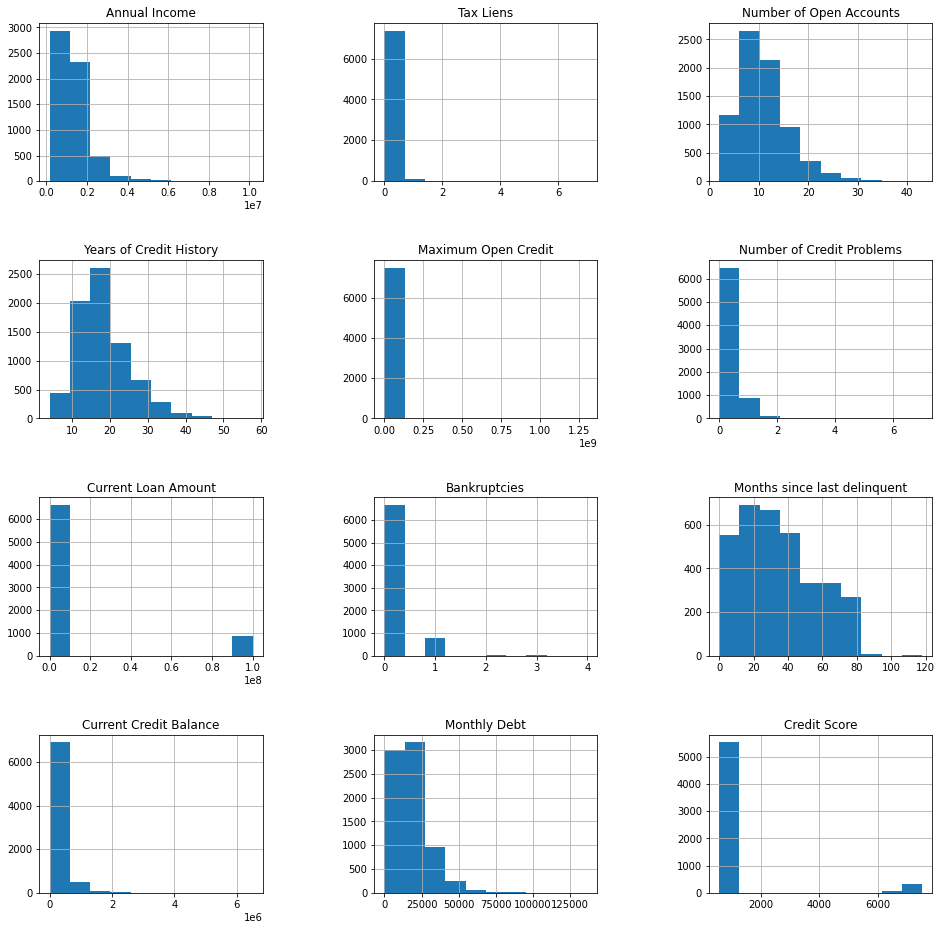

In [13]:
# распределение признаков в тренировочном датасете
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

#### Изучим отдельные признаки подробнее

#### Annual Income - Годовой доход

In [4043]:
df_train['Annual Income'].isnull().sum()

1557

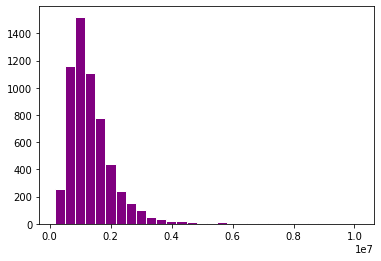

In [4045]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(df_train['Annual Income'], bins = 30, color = 'purple', ec = 'white')

plt.show()

Доход - очень индивидуальный признак, повторяющихся значений очевидно мало, в данном случае все его значения можно допустить и не причислять к выбросам

In [32]:
#Вариант 1. 
# Добавляем признак о неизвестном доходе и присваиваю всем наблюдениям 0
#df_train['Unknown Income'] = 0
# Всем, у кого неизвестна зарплата делаем пометку "1" в столбец unknown_income
#df_train.loc[(df_train['Annual Income'].isnull()), 'Unknown Income'] = 1

# Вариант 2

#train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median(), inplace = True)



#### Current Loan Amount - Текущий кредитный баланс

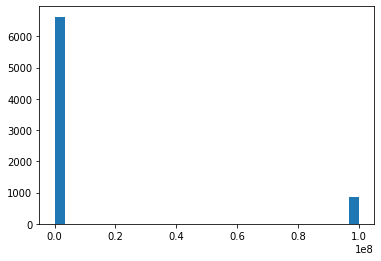

In [54]:
fig, ax = plt.subplots(nrows = 1, ncols = 1)
ax.hist(df_train['Current Loan Amount'], bins = 30)
plt.show()

In [34]:
df_train['Current Loan Amount'].value_counts()

100000000.0    870
89298.0          6
218064.0         6
216106.0         5
265826.0         5
              ... 
222860.0         1
104324.0         1
201080.0         1
427812.0         1
191136.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

In [4052]:
df_train.loc[df_train['Current Loan Amount'] == 100000000, 'Current Loan Amount'].count()

870

Значение 100000000.0 будем считать выбросом. Далее рассмотрим, как лучше всего его обработать

Можно допустить, что это не выброс, а только взятые кредиты, но такое большое количество одинаковых значений выглядит странно. Рассмотрим разные варианты работы с этим признаком

In [4053]:
# Заменим отличительно большие значения признака (выбросы), определенные выше, на среднее значение
df_train.loc[df_train["Current Loan Amount"] > 1000000, "Current Loan Amount"] = df_train.loc[df_train["Current Loan Amount"] <= 1000000, "Current Loan Amount"].mean()

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

<AxesSubplot:>

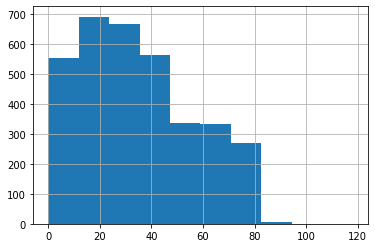

In [62]:
df_train['Months since last delinquent'].hist()

In [60]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
33.0     68
8.0      68
19.0     65
         ..
84.0      1
86.0      1
91.0      1
118.0     1
92.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [61]:
df_train['Months since last delinquent'].isnull().sum()

4081

У признака Months since last delinquent очень низкая корреляция с целевой переменной, возможно имеет смысл его удалить и не использовать в построении итоговой модели

In [4038]:
#df_train.drop(columns = 'Months since last delinquent', axis = 1, inplace = True) - удаление

#### Credit Score

Этот признак не описан среди заданных, допустим, что он предполагает некую характеристику клиента банка, расчитанную аналитиками на основе неких показателей. Поэтому отнесем его к категориальным

In [4054]:
df_train['Credit Score'].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
742.0     151
         ... 
629.0       1
606.0       1
6830.0      1
6670.0      1
620.0       1
Name: Credit Score, Length: 268, dtype: int64

In [90]:
df_train['Credit Score'].value_counts().count()

268

In [93]:
df_train['Credit Score'].sort_values(ascending = False)

2213    7510.0
3688    7510.0
2408    7500.0
355     7500.0
1363    7490.0
         ...  
7482       NaN
7492       NaN
7494       NaN
7498       NaN
7499       NaN
Name: Credit Score, Length: 7500, dtype: float32

In [4056]:
df_train['Credit Score'].isnull().sum()

1557

Поскольку предполагаем, что этот признак - некая расчетная величина, определенная по некоторым признакам клиентов, количество ее значений вполне доступимо может быть большим.

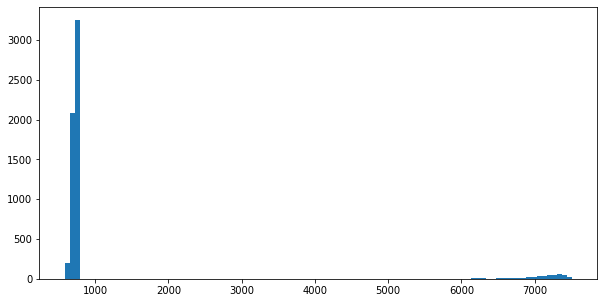

In [94]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
ax.hist(df_train['Credit Score'], bins = 100)
plt.show()

Виден просвет между значениями примерно 700 и 6000, после чего идет длинный "хвост" из явно небольшого количества наблюдений. Расчитаем сколько их и какое значение наибольшее до этого "хвоста"

In [4058]:
df_train.loc[df_train['Credit Score'] <=1000, 'Credit Score'].max()

751.0

In [95]:
df_train['Credit Score'].min()

585.0

In [4060]:
df_train.loc[df_train['Credit Score'] >= 1000, 'Credit Score'].count()

400

In [4062]:
df_train['Credit Score'].isnull().sum()

1557

Значений "хвоста" немного, примем их за выбросы и уберем их. Оставшиеся значения распределены в промежутке между 585 и 751 (относительно генеральной совокупность этот интервал маленький) -> вполне допустимо заполнить пропуски средним или медианой. 

* попробуем разные варианты, но пока я рассматриваю медиану

In [96]:
#train_df["Annual Income"] = train_df["Annual Income"].fillna(train_df["Annual Income"].median(), inplace = True)

In [98]:
df_train['Credit Score'].isnull().sum() #должен быть 0 после заполнения пропусков

1557

#### Months since last delinquent - Количество месяцев с последней просрочки платежа

Самое большое количество пропусков - более 50%!

In [117]:
df_train['Months since last delinquent'].isnull().sum()

4081

В соответствии с матрицей корреляций линейной связи с целевой переменной практически нет. Учитывая более половины пропущенных значений и большому количеству признаков датасета (включая предполагаемые дамми), имеет смысл попробовать исключить этот признак.

### Матрица корреляций

<AxesSubplot:>

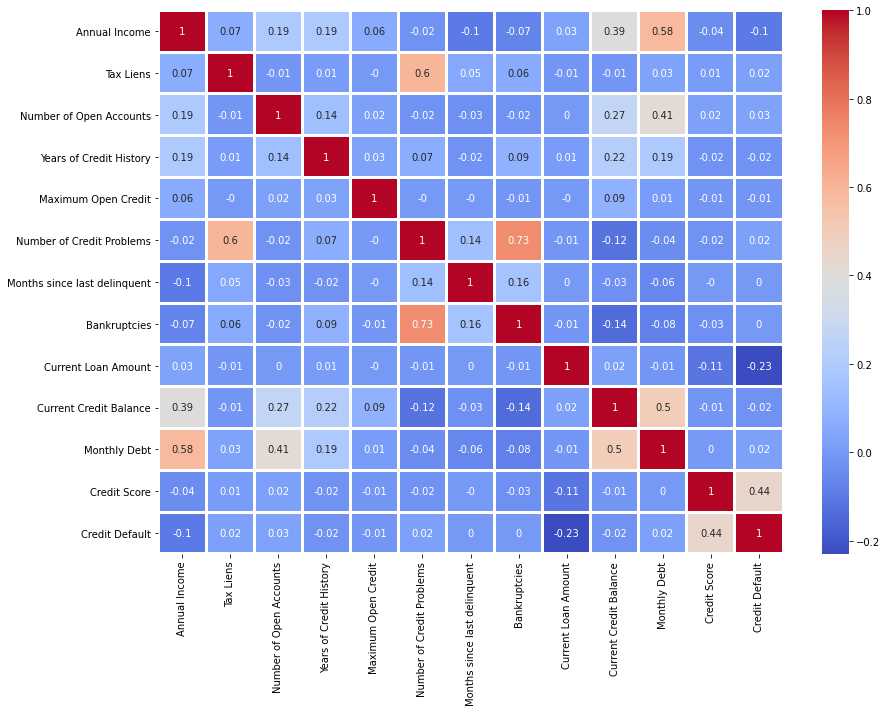

In [4035]:
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix,2)
plt.figure(figsize = (14,10))
sns.heatmap(corr_matrix, annot=True, linewidth = 2, cmap = 'coolwarm')

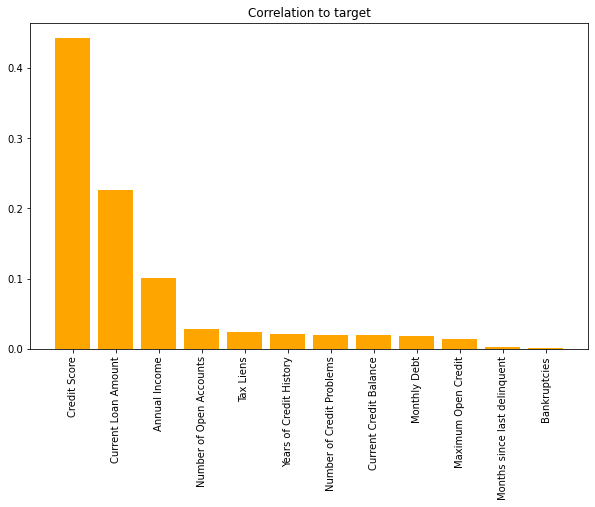

In [115]:
corr_matrix = df_train.corrwith(df_train['Credit Default'])
corr_matrix = df_train.loc[:, df_train.columns != 'Credit Default'].corrwith(df_train['Credit Default']).abs().sort_values(ascending=False)
plt.figure(figsize = (10, 6))
plt.bar(corr_matrix.index, corr_matrix.values, color = 'orange')
plt.title('Correlation to target')
plt.xticks(rotation='vertical')
plt.show()

### Категориальные признаки

#### Years in Current Job

In [67]:
years_job = df_train['Years in current job'].value_counts()

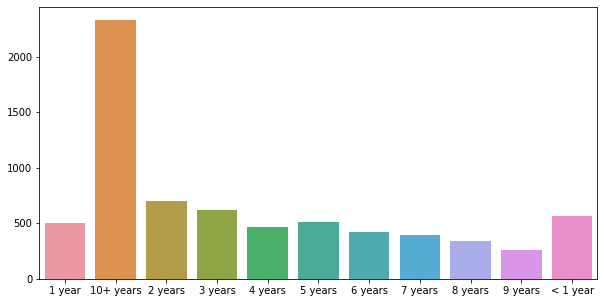

In [77]:
plt.figure(figsize = (10,5))
sns.barplot(years_job.index, years_job.values)
plt.show()

Примечательно, что с увеличением количества лет на работе до 9, сокращается количество людей, работающих на одной и той же работе, однако работающих 10 лет и более - подавляющее большинство!

#### Purpose - цель кредита

In [80]:
purpose_values = df_train['Purpose'].value_counts()

<AxesSubplot:>

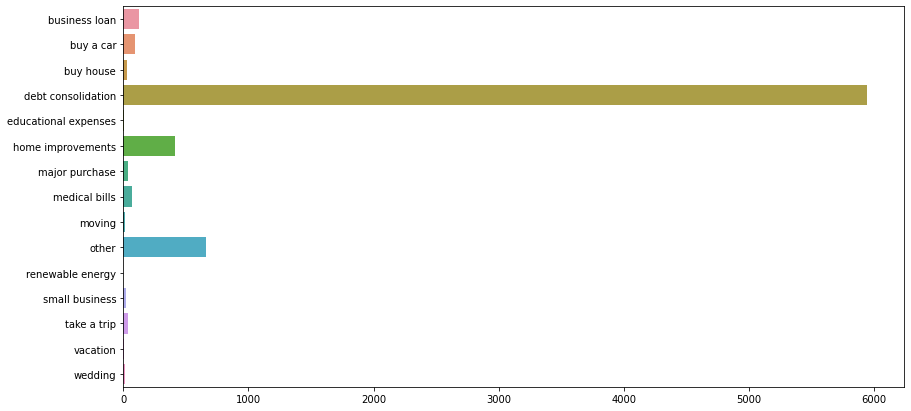

In [85]:
plt.figure(figsize = (14,7))
sns.barplot(purpose_values.values, purpose_values.index)

In [89]:
df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'].count()

5944

Очевидно существенное преобладание значения "debt consolidation", значения остальных признаков сильно малы в общем объеме значений.
Можно будет рассмотреть вариант объединения всех остальных признаков в один и закодировать дамми или 0 - "debt consolidation" и 1 - все остальные
Или же можно перевести все в дамми , искуственно увеличивая число признаков, описывающих объекты. 
Буду проверять разные гипотезы при построении модели и получении ее результатов


In [103]:
#Вариант 1
#df_train.loc[df_train['Purpose'] == 'debt consolidation', 'Purpose'] = 1
#df_train.loc[df_train['Purpose'] != 'debt consolidation', 'Purpose'] = 0

#Вариант2
#Перевод всех категорий признака в дамми 


#### Bankruptcies   - банкротства         

In [57]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Видимо, значение признака предполагает количество банкротств юр. лиц , зарегистрированных на клиента. Т.к. обычно бОльшая часть население не имеет зарегистрированных на себя фирм, то значение 0 преобладает. Однако есть клиенты, кто видимо неоднократно пытался начать свой бизнес и терпел неудачу, количество таких лиц стремительно сокращается. Допускаю, что значения признака адекватны в данном случае.

#### Home Ownership   - домовладение         

In [123]:
df_train['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

Предположим, что Have Mortgage - выброс, возникший в результате опечатки и заменим 12 значений на Home Mortgage

In [124]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', "Home Ownership"] = 'Home Mortgage'

### Категориальные признаки переводим в dummies

In [4079]:
df_train.select_dtypes(include='category').columns

Index(['Home Ownership', 'Purpose', 'Term'], dtype='object')

Исходя из смысла признаков, можно сделать вывод, что кодировать порядковыми номерами и закодировать бинарно (0,1) нецелесообразно

Переводим категориальные признаки в дамми

In [4081]:
for cat_colname in CAT_FEATURE_NAMES:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname])], axis=1)

In [4082]:
df_train.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,482087.0,0.0,11.0,26.299999,685960.0,1.0,debt consolidation,Short Term,309024.40625,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,0.0,15.0,15.300000,1181730.0,0.0,debt consolidation,Long Term,264968.00000,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,0.0,11.0,35.000000,1182434.0,0.0,debt consolidation,Short Term,309024.40625,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,0.0,8.0,22.500000,147400.0,1.0,debt consolidation,Short Term,121396.00000,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,0.0,13.0,13.600000,385836.0,1.0,debt consolidation,Short Term,125840.00000,...,0,0,0,0,0,0,0,0,0,0


In [4083]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Home Ownership             7500 non-null   category
 1   Annual Income              7500 non-null   float32 
 2   Tax Liens                  7500 non-null   float32 
 3   Number of Open Accounts    7500 non-null   float32 
 4   Years of Credit History    7500 non-null   float32 
 5   Maximum Open Credit        7500 non-null   float32 
 6   Number of Credit Problems  7500 non-null   float32 
 7   Purpose                    7500 non-null   category
 8   Term                       7500 non-null   category
 9   Current Loan Amount        7500 non-null   float32 
 10  Current Credit Balance     7500 non-null   float32 
 11  Monthly Debt               7500 non-null   float32 
 12  Credit Score               7500 non-null   float32 
 13  Credit Default             7500 n

In [4084]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default', 'Have Mortgage', 'Home Mortgage',
       'Own Home', 'Rent', 'Long Term', 'Short Term', 'business loan',
       'buy a car', 'buy house', 'debt consolidation', 'educational expenses',
       'home improvements', 'major purchase', 'medical bills', 'moving',
       'other', 'renewable energy', 'small business', 'take a trip',
       'vacation', 'wedding'],
      dtype='object')

#### Переопределим признаки

#требует корректировки исходя из тех признаков, которые оставим для построения модели

In [4078]:
BASE_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership',
                    'Term', 'Purpose']

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Number of Credit Problems', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Term', 'Purpose']

### Нормализация данных


In [4085]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [4086]:
df_train.head()

,Home Ownership,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Purpose,Term,Current Loan Amount,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,-1.114304,-0.110953,-0.026674,1.133645,-0.016174,1.664779,debt consolidation,Short Term,8.202912e-08,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,-0.396190,-0.110953,0.788223,-0.428528,0.014763,-0.340979,debt consolidation,Long Term,-2.570651e-01,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,-0.758385,-0.110953,-0.026674,2.369181,0.014807,-0.340979,debt consolidation,Short Term,8.202912e-08,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,-0.687478,-0.110953,-0.637847,0.593985,-0.049781,1.664779,debt consolidation,Short Term,-1.094795e+00,...,0,0,0,0,0,0,0,0,0,0
4,Rent,-0.725543,-0.110953,0.380774,-0.669954,-0.034903,1.664779,debt consolidation,Short Term,-1.068865e+00,...,0,0,0,0,0,0,0,0,0,0
